# **Exploring the Use of Artificial Curiosity in MNIST Image Classification**

Shreyas DB

## **Abstract**

The project focuses on developing an FFN (Feed-Forward Network) model with a unique feature of "Artificial Curiosity". Artificial Curiosity in the context of this project is a process that involves applying affine transformations to input test data and using a model trained on regular; non-transformed data to predict on the transformed data. The model then filters the predictions based on the least entropy for log-softmax values, specifically softmax values. The choice of the word "curiosity" to describe the process of applying different transformations to test images makes sense, as it reflects the idea of exploring different possibilities to make a prediction. The model is "curiosity-driven" in the sense that it explores different possibilities of orientations and mirroring of the test image in order to make a prediction, rather than relying solely on what it was trained on. This demonstrates some level of creativity in the sense that the model is able to find new ways of solving the problem of image recognition, rather than just being limited to what it was trained on. While the number and types of transformations used in this project are limited for demonstration purposes, the concept of artificial curiosity can be extended to include a range of creative transformations. This project uses a feed-forward neural network (FFN) because FFNs lack spatial perception and are unable to recognize images that do not resemble the training data. This weakness of FFNs is exploited to demonstrate the concept of artificial curiosity. When the model is predicting with 'curious' mode, it can recognize manipulated images, while in 'standard' mode, it cannot. This distinction provides a clear demonstration of the advantages and limitations of the two modes.

## **Establish connection with GitHub using SSH protocol.**

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ssh keys were generated earlier. Private and Public keys are stored in 
# 'colabkey' and 'colabkey.pub' files. Additionally a config file is also 
# stored in /content/drive/MyDrive/ssh_keys/ on google drive.

# Remove ssh folder and its contents if already present
!rm -rf /root/.ssh

# Create a directory
!mkdir /root/.ssh

# Copy everything (ssh_key files & config file) from google drive to Virtual Machine.  
!cp /content/drive/MyDrive/ssh_keys/* /root/.ssh

# Set permission
!chmod 700 /root/.ssh  

In [3]:
# Add the git server as an ssh known host
!touch /root/.ssh/known_hosts

# Trust github  
!ssh-keyscan github.com >> /root/.ssh/known_hosts

# Set permission  
!chmod 644 /root/.ssh/known_hosts  

# github.com:22 SSH-2.0-babeld-30fa67d5
# github.com:22 SSH-2.0-babeld-30fa67d5
# github.com:22 SSH-2.0-babeld-30fa67d5
# github.com:22 SSH-2.0-babeld-30fa67d5
# github.com:22 SSH-2.0-babeld-30fa67d5


In [4]:
# Run ssh-agent and add `ssh-add /root/.ssh/colabkey` in the prompt. 
# After this command, optinally check if the key is saved using `ssh-add -l`, 
# then exit the prompt.
!ssh-agent /bin/bash

bash: cannot set terminal process group (134): Inappropriate ioctl for device
bash: no job control in this shell
/content# ssh-add /root/.ssh/colabkey
Identity added: /root/.ssh/colabkey (shreyasdb99@gmail.com)
/content# exit
exit


In [5]:
# Check connection with github
!ssh -T git@github.com

Hi shre-db! You've successfully authenticated, but GitHub does not provide shell access.


In [6]:
# Navigate to the project folder
cd drive/MyDrive/ColabProjects/A-Curious-FFN

/content/drive/MyDrive/ColabProjects/A-Curious-FFN


In [7]:
!ls

A_Curious_FFN.ipynb  images  LICENSE.txt  README.md


## **Initialize git repository if not already**

In [ ]:
# # Initialize the directory as a git repository (if not already)
# !git init

Initialized empty Git repository in /content/drive/MyDrive/ColabProjects/A-Curious-FFN/.git/


In [ ]:
# # Configure user name and email (if not already)
# !git config user.name "shre-db"
# !git config user.email "shreyasdb99@gmail.com"

In [ ]:
# # Check Staging Area
# !git status

On branch master

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	A_Curious_FFN.ipynb
	README.md

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
# # Add Commit and Push
# !git add README.md 
# !git add A_Curious_FFN.ipynb
# !git commit -m "Add README and Notebook" -m "This commit includes a basic FFN model."
# !git branch -M main
# !git remote add origin git@github.com:shre-db/A-Curious-FFN.git
# !git push -u origin main

[master (root-commit) 8c88448] Add README and Notebook
 2 files changed, 1 insertion(+)
 create mode 100644 A_Curious_FFN.ipynb
 create mode 100644 README.md
Enumerating objects: 4, done.
Counting objects: 100% (4/4), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 26.65 KiB | 4.44 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0)
To github.com:shre-db/A-Curious-FFN.git
 * [new branch]      main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


## **Use cells in this section to execute commands**

In [8]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   A_Curious_FFN.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git pull

Already up to date.


In [ ]:
!git add A_Curious_FFN.ipynb
!git commit -m "Update notebook" -m "Minor corrections in stating Null and Alternate Hypothesis."
!git push

[main 184d060] Add .gitignore file and images folder
 2 files changed, 1 insertion(+)
 create mode 100644 .gitignore
 create mode 100644 images/cover.png
Enumerating objects: 6, done.
Counting objects: 100% (6/6), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 374.81 KiB | 5.43 MiB/s, done.
Total 5 (delta 0), reused 0 (delta 0)
To github.com:shre-db/A-Curious-FFN.git
   48b86dd..184d060  main -> main


## **Working with data**

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ttest_ind
import scipy.stats as stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import cv2
import sys

In [ ]:
# Gather original MNIST data.
from sklearn.datasets import fetch_openml
mnist_org = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

In [ ]:
mnist_org.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
data = mnist_org.data
data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
targets = mnist_org.target
targets

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
print(data.min())
print(data.max())

0
255


In [ ]:
# Scale the data using minmax scaler to a range of 0 - 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
data.dtype

dtype('float64')

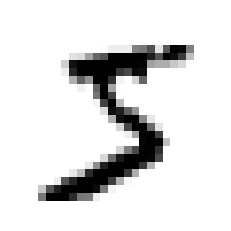

In [ ]:
# Plot an image

number = data[0,:].reshape(28, 28)

plt.imshow(number, mpl.cm.binary)
plt.axis("off")
plt.show()

## **Create Train and Test groups using DataLoader**

In [ ]:
# Convert data and labels to pytorch tensors
dataT = torch.tensor(data).float()
targT = torch.tensor(targets.astype(int)).long()

In [ ]:
# Split the data into train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=42)
for train_index, test_index in ss_split.split(dataT, targT):
  X_train, X_test, y_train, y_test = dataT[train_index, :], dataT[test_index, :], targT[train_index], targT[test_index] 

In [ ]:
# Convert to Pytorch Datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [ ]:
# Translate into dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## **Create a Feed Forward Network**

In [ ]:
# Define an abstract base class for curiosity
from abc import ABC, abstractmethod

class BaseCuriosity(ABC):
  """
  Abstract Base Class to ensure consistent interface across all concrete classes.
  All concrete classes should implement `curiosity` method.
  """
  def __init__(self, mode='curious'):
    self.mode = mode

  @abstractmethod
  def curiosity(self):
    pass

In [ ]:
class CuriousFFN(nn.Module, BaseCuriosity):
  """
  Defines model architecture and curiosity in the context of MNIST image classfication.

  Parameters:
  -----------
  mode : str, (default: 'standard')
    - If 'standard', calls forward method, the model behaves like a normal FFN.
    - If 'curious', calls curiosity method, the model incorporates artificial curiosity while predicting class of input image.

  info: bool, (default: False)
    - If True, prints informations about prediction like Flip, Azimuth, Softmax and Entropy. Also plots an images and barplot.
    - If False, prints nothing. 

  Note:
  -----
  While training use 'standard' mode and while predicting use any of the two.
  """
    
  # Initialize mode, input layer, hidden layers, output layer and their number of units respectively.
  def __init__(self, mode='standard', info=False) -> None:
    super().__init__()
    self.mode = mode
    self.info = info

    # input layer
    self.input = nn.Linear(784, 64)

    # hidden layers
    self.hidden1 = nn.Linear(64, 64)
    self.hidden2 = nn.Linear(64, 64)

    # output layer
    self.output = nn.Linear(64, 10)

  # Customize nn.Module's __call__ method to change behaviour of the model.
  def __call__(self, inp):
    if self.mode == 'standard':
      return self.forward(inp)
    elif self.mode == 'curious':
      return self.curiosity(inp)
    else:
      raise ValueError(f"Invalid mode '{self.mode}'")

  # Forward pass
  def forward(self, X):
    X = F.relu(self.input(X))
    X = F.relu(self.hidden1(X))
    X = F.relu(self.hidden2(X))
    # return raw output
    return torch.log_softmax(self.output(X), axis=1)

  # Artificial Curiosity
  def curiosity(self, img_data):
    """
    Incorporates artificial curiosity while predicting class of input images.

    Parameters:
    -----------
    img_data: arraylike
      - The input image data, preferrably as a pytorch tensor.

    Returns:
    --------
    prediction: tensor
      - The predicted class of the input image.

    Notes:
    -----
    "Artificial curiosity in the context of the project is a process that involves applying affine transformations to input data and using a model to predict on the transformed data. The model then filters the predictions based on the least entropy for log-softmax values, specifically softmax values. In this project, the model explores different orientations and flips of the input data to identify patterns and enhance its performance. While the number and types of transformations used in this project are limited for demonstration purposes, the concept of artificial curiosity can be extended to include a range of creative transformations.
    This project uses a feed-forward neural network (FFN) because FFNs lack spatial perception and are unable to recognize images that do not resemble the training data. This weakness of FFNs is exploited to demonstrate the concept of artificial curiosity. When the model is predicting with 'curious' mode, it can recognize manipulated images, while in 'standard' mode, it cannot. This distinction provides a clear demonstration of the advantages and limitations of the two modes.
    Affine transformations are a type of transformation that preserves parallel lines, angles, and distances in an image. Log-softmax values are the logarithm of the softmax function, which converts the output of a neural network into a probability distribution over the possible classes. By using the least entropy for log-softmax values, the model can make more confident predictions.
    Overall, this project demonstrates how artificial curiosity can be used to improve a model's performance by exploring and adapting to novel input data, even if the data has been manipulated. ". 
    """

    # 1. Convert image data to numpy array if not already.
    if type(img_data) != 'numpy.ndarray':
        img_data = np.array(img_data.reshape(28,28).detach())
    img = img_data.copy()

    # 4. Repeat steps 2 and 3 for a certain number of iterations.
    softmax_tensors = []
    entropies = []
    for flip in range(2):
      for azimuth in range(0,360,45):

        # 2. Apply transformation.
        rows, cols = img.shape[:2]
        center = (cols/2, rows/2)
        rotation_matrix = cv2.getRotationMatrix2D(center, azimuth, 1)
        rotated_image = cv2.warpAffine(img, rotation_matrix,  (cols, rows))
        rotated_image = torch.tensor(rotated_image).reshape(1, -1)

        # 3. Forward pass
        logsoftmax_pred = self.forward(rotated_image)

        # 5. Convert log-softmax tensor to softmax tensor.
        softmax_pred = torch.exp(logsoftmax_pred)

        # 6. Store softmax tensor.
        softmax_tensors.append(softmax_pred)

        # 7. Calculate entropy for softmax tensor.
        cat_dist = torch.distributions.Categorical(softmax_pred.detach().reshape(-1))
        entropy = cat_dist.entropy()
        entropies.append(entropy)

        # print statements
        if self.info:
          print(f"Flip: {flip}\n Azimuth: {azimuth} deg\n Softmax: {softmax_pred.detach().reshape(-1)}\n Entropy: {entropy}")

          fig, ax = plt.subplots(1, 2, figsize=(12,6))
          ax[0].imshow(rotated_image.reshape(28, 28), mpl.cm.binary)
          ax[0].axis("off")

          ax[1].bar(np.arange(0,10), softmax_pred.detach().reshape(-1).numpy())
          ax[1].set_xticks(np.arange(0,10,1))
          ax[1].set_xlabel('numbers')
          ax[1].set_ylabel('probability')
          plt.show()
          plt.pause(0.1)
          print(' \n ')

      # 8. Mirror the original image data before proceeding for next iteration of outer loop.
      img = cv2.flip(img_data, 0)

    # 9. Return the instance with lowest entropy value as prediction.
    min_idx = entropies.index(min(entropies))
    prediction = torch.argmax(softmax_tensors[min_idx])

    return prediction 


In [ ]:
def createCuriousFFN():
  # Model instance
  net = CuriousFFN(mode='standard')
  
  # Loss funtion
  lossfun = nn.NLLLoss()

  # Optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  return net, lossfun, optimizer


In [ ]:
def trainCuriousFFN(net, lossfun, optimizer):
  """
  A function to train an FFN model.
  """
  # Set number of iterations for training
  numepochs = 20

  # Initialize losses and accuracies
  losses = torch.zeros(numepochs)
  train_acc = []
  test_acc = []

  # Loop over numepochs
  for epoch in range(numepochs):

    # Initialize batch losses and accuracies
    batch_loss = []
    batch_acc = []

    # Loop over minibatches from train_loader
    for X, y in train_loader:

      # Forward prop
      yHat = net(X)

      # Loss function
      loss = lossfun(yHat, y)

      # Back prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute and store losses from this batch
      batch_loss.append(loss.item())

      # Compute and store accuracies
      batch_acc.append(torch.mean((torch.argmax(yHat,axis=1) == y).float())*100)
        
    # Compute and store average loss across batches
    losses[epoch] = np.mean(batch_loss)

    # Compute and store average training acuracy
    train_acc.append(np.mean(batch_acc))

    # Test accuracy
    X, y = next(iter(test_loader))
    with torch.no_grad():
        yHat = net(X)

    # Compute and store test accuracy
    test_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float())*100)

  return net, losses, train_acc, test_acc

In [ ]:
# Create a model
ffn, lossf, optim = createCuriousFFN()

# Train the model
ffn, losses, train_acc, test_acc = trainCuriousFFN(net=ffn, lossfun=lossf, optimizer=optim)

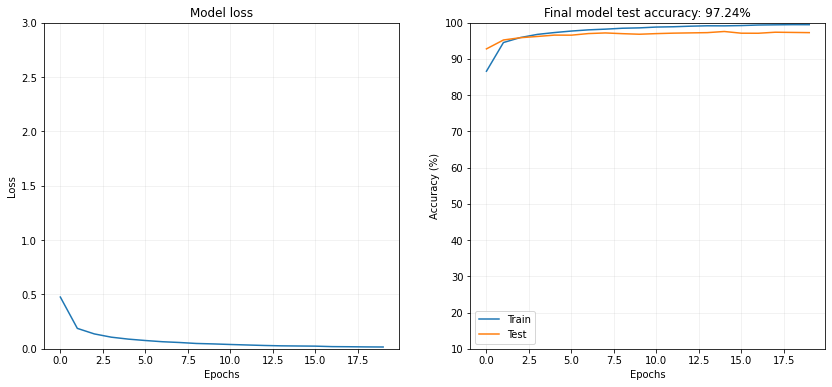

In [ ]:
# Visualize the performance
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[0].grid(alpha=0.2)

ax[1].plot(train_acc,label='Train')
ax[1].plot(test_acc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()
ax[1].grid(alpha=0.2)

plt.show()

## **Testing Curiosity of the model**

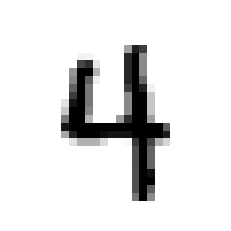

tensor(4)


In [ ]:
sample_image= next(iter(test_loader))[0][67].reshape(28, 28)
sample_label = next(iter(test_loader))[1][67]

plt.imshow(sample_image, mpl.cm.binary)
plt.axis("off")
plt.show()

print(sample_label)

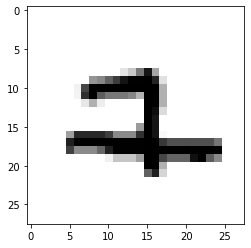

In [ ]:
# Manipulate test image before feeding it to the trained model for prediction.
sample_image = np.array(sample_image.detach())
sample_image = cv2.flip(sample_image, 1) 
rows, cols = sample_image.shape[:2]
center = (cols/2, rows/2)
angle = 90
angle_rad = angle * np.pi / 180
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
rotated_image = cv2.warpAffine(sample_image, rotation_matrix,  (cols, rows))
sample_image = torch.tensor(rotated_image.reshape(1, -1))
plt.imshow(rotated_image, mpl.cm.binary)
plt.show()
# The image is flipped and rotated by 90 degrees, let's see if the trained FFN is able to recognize the digit using its curiosity.

In [ ]:
ffn.mode = 'standard'
ffn.info = True
output = ffn(sample_image)
output

tensor([[-2.9187e+01, -1.5300e+01, -1.1837e-04, -1.0514e+01, -1.2065e+01,
         -2.4267e+01, -2.2990e+01, -9.3698e+00, -2.9958e+01, -1.8107e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [ ]:
torch.argmax(output, axis=1)

tensor([2])

With 'standard' mode the model predicts that the input image is '2'. Let's see what happens with the 'curious' mode.

Flip: 0
 Azimuth: 0 deg
 Softmax: tensor([2.1089e-13, 2.2665e-07, 9.9988e-01, 2.7146e-05, 5.7569e-06, 2.8905e-11,
        1.0365e-10, 8.5259e-05, 9.7604e-14, 1.3679e-08])
 Entropy: 0.0012757946969941258


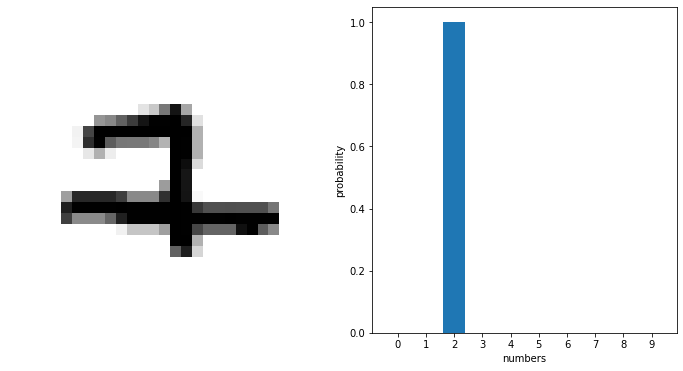

 
 
Flip: 0
 Azimuth: 45 deg
 Softmax: tensor([9.2931e-04, 2.6689e-05, 3.9679e-04, 4.6864e-07, 1.9795e-02, 5.0656e-07,
        9.7849e-01, 3.5366e-04, 3.4141e-06, 3.3576e-06])
 Entropy: 0.11170496791601181


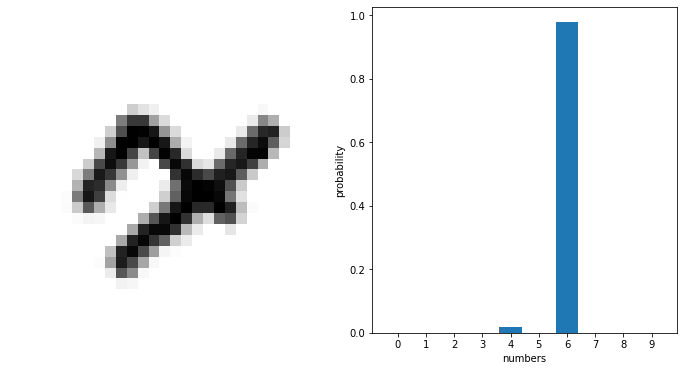

 
 
Flip: 0
 Azimuth: 90 deg
 Softmax: tensor([3.4538e-08, 3.4149e-08, 5.0098e-03, 4.9050e-06, 9.9497e-01, 9.3653e-12,
        2.1011e-10, 1.3987e-05, 1.9046e-09, 3.2554e-06])
 Entropy: 0.03181176260113716


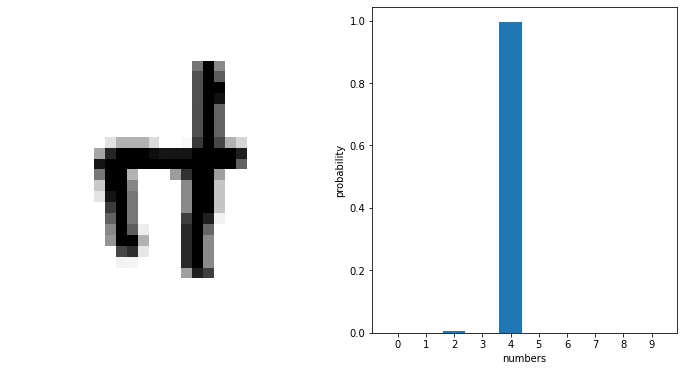

 
 
Flip: 0
 Azimuth: 135 deg
 Softmax: tensor([2.1376e-07, 2.0683e-06, 9.9520e-01, 3.4847e-03, 3.4359e-08, 1.9482e-11,
        2.1895e-08, 1.3098e-03, 6.8333e-08, 2.8039e-13])
 Entropy: 0.033233314752578735


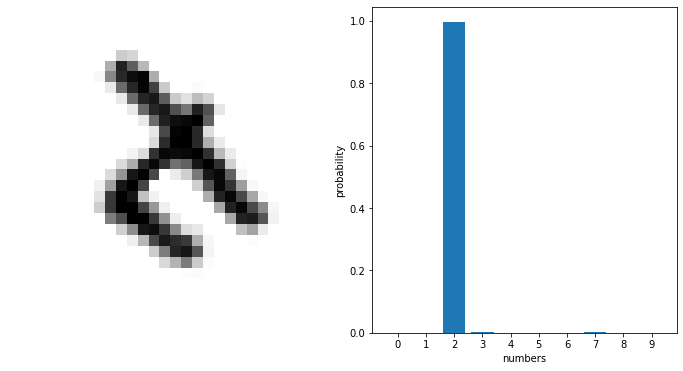

 
 
Flip: 0
 Azimuth: 180 deg
 Softmax: tensor([1.2224e-06, 7.7887e-07, 1.0306e-02, 4.4459e-05, 2.5076e-10, 3.5969e-04,
        6.6890e-09, 9.8924e-01, 4.5683e-05, 1.0844e-08])
 Entropy: 0.06163335591554642


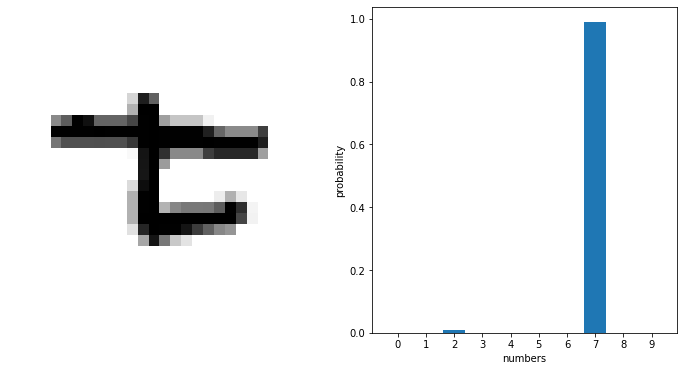

 
 
Flip: 0
 Azimuth: 225 deg
 Softmax: tensor([7.4071e-07, 2.6069e-10, 1.8781e-04, 1.4240e-08, 9.9981e-01, 2.5339e-11,
        7.5460e-07, 6.4218e-09, 9.7923e-11, 9.3881e-09])
 Entropy: 0.0018223701044917107


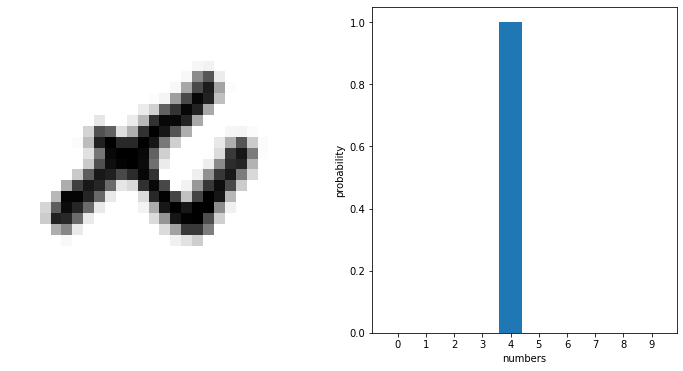

 
 
Flip: 0
 Azimuth: 270 deg
 Softmax: tensor([3.8929e-10, 7.7784e-15, 1.4486e-08, 7.3935e-14, 1.0000e+00, 5.1840e-12,
        1.6595e-11, 1.0786e-09, 1.0078e-11, 8.1075e-11])
 Entropy: 3.75349884507159e-07


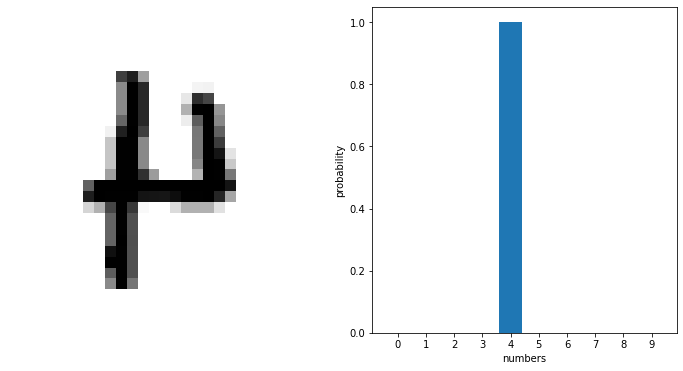

 
 
Flip: 0
 Azimuth: 315 deg
 Softmax: tensor([1.4710e-04, 1.4403e-07, 6.4292e-04, 2.2619e-04, 5.6227e-06, 9.3817e-05,
        1.1101e-03, 1.3927e-07, 9.9638e-01, 1.3898e-03])
 Entropy: 0.02916875295341015


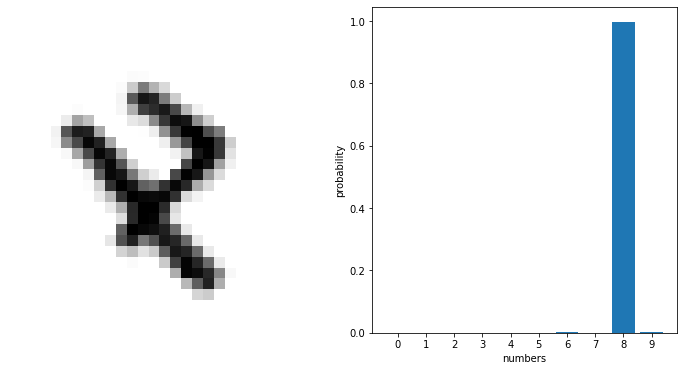

 
 
Flip: 1
 Azimuth: 0 deg
 Softmax: tensor([6.9730e-09, 6.4533e-08, 3.9536e-06, 4.3596e-05, 8.7190e-10, 2.5743e-08,
        2.0049e-14, 9.9705e-01, 1.2924e-06, 2.8966e-03])
 Entropy: 0.020375438034534454


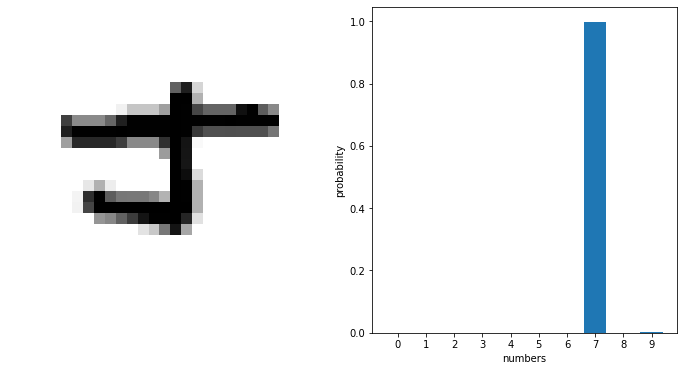

 
 
Flip: 1
 Azimuth: 45 deg
 Softmax: tensor([2.3832e-07, 1.4964e-05, 3.8711e-08, 4.1717e-09, 9.0568e-07, 2.6461e-05,
        9.9996e-01, 1.1521e-07, 1.7802e-07, 8.0522e-08])
 Entropy: 0.0005108737386763096


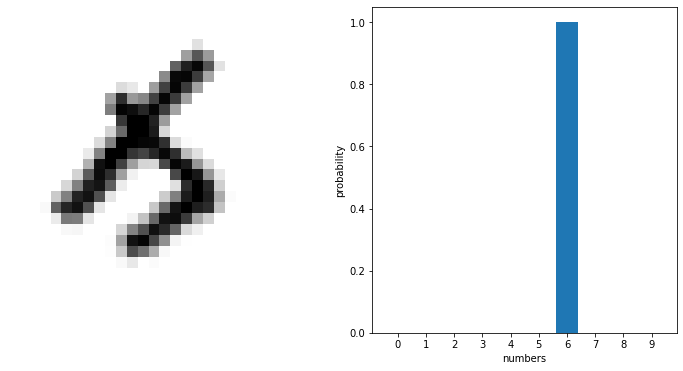

 
 
Flip: 1
 Azimuth: 90 deg
 Softmax: tensor([5.9679e-08, 2.3518e-10, 1.1889e-08, 6.6162e-09, 3.0454e-05, 4.8066e-01,
        5.1847e-01, 5.1888e-10, 8.3941e-04, 3.3830e-08])
 Entropy: 0.6989622712135315


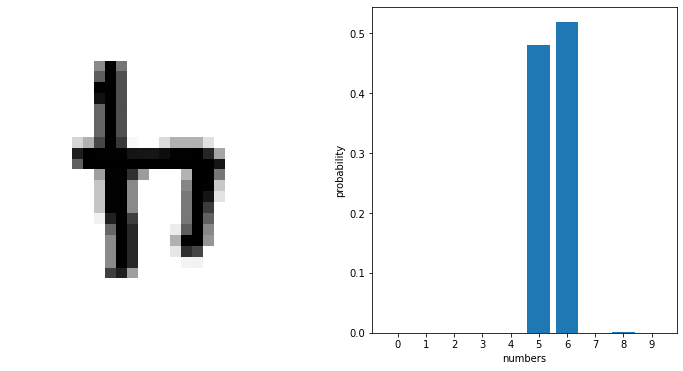

 
 
Flip: 1
 Azimuth: 135 deg
 Softmax: tensor([7.1043e-01, 1.4731e-08, 4.3419e-07, 4.9830e-06, 2.8495e-04, 3.7264e-06,
        2.8910e-01, 2.3242e-09, 5.3844e-07, 1.7888e-04])
 Entropy: 0.6056451201438904


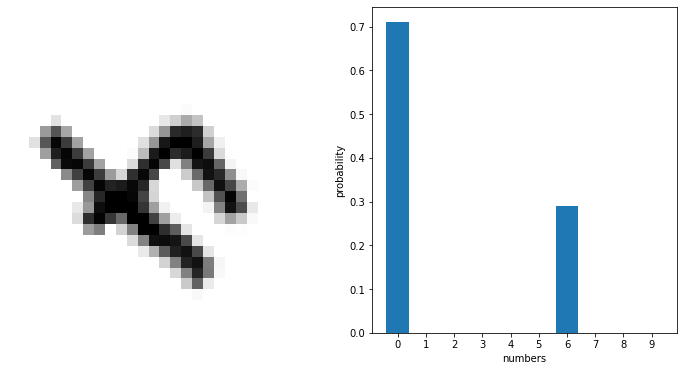

 
 
Flip: 1
 Azimuth: 180 deg
 Softmax: tensor([2.6619e-07, 1.3268e-05, 5.0080e-02, 1.5677e-03, 6.8356e-07, 1.2742e-02,
        9.3556e-01, 7.0543e-08, 3.1252e-05, 4.8378e-11])
 Entropy: 0.27846407890319824


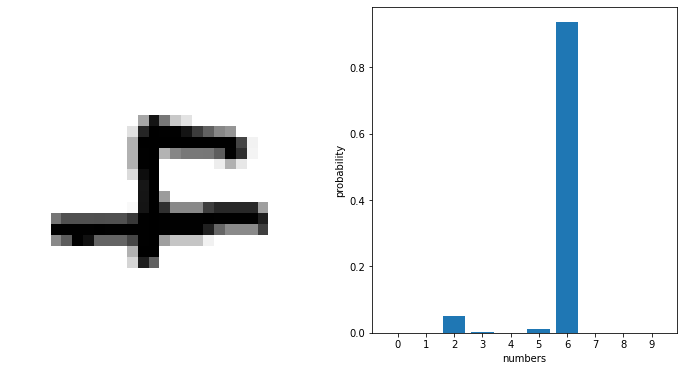

 
 
Flip: 1
 Azimuth: 225 deg
 Softmax: tensor([3.6823e-03, 8.4241e-06, 2.8040e-01, 1.3375e-01, 6.4077e-03, 6.2949e-05,
        2.5129e-04, 2.9755e-03, 6.2787e-03, 5.6618e-01])
 Entropy: 1.052617073059082


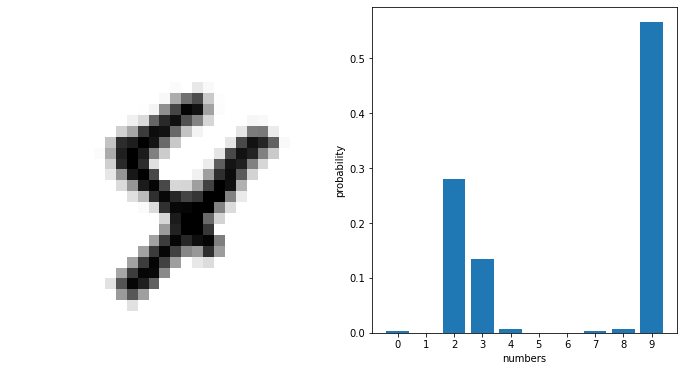

 
 
Flip: 1
 Azimuth: 270 deg
 Softmax: tensor([6.2691e-15, 2.2042e-13, 6.0649e-08, 1.9390e-13, 1.0000e+00, 2.3819e-17,
        1.1646e-15, 3.7553e-11, 1.8854e-15, 7.4736e-10])
 Entropy: 1.0986142342517269e-06


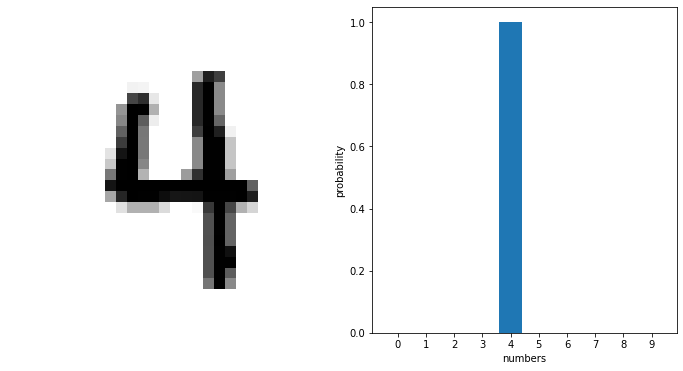

 
 
Flip: 1
 Azimuth: 315 deg
 Softmax: tensor([8.1760e-06, 4.1209e-11, 4.6408e-07, 1.1075e-08, 8.5040e-01, 2.2211e-08,
        1.3477e-09, 1.9819e-03, 5.9985e-08, 1.4761e-01])
 Entropy: 0.4326472580432892


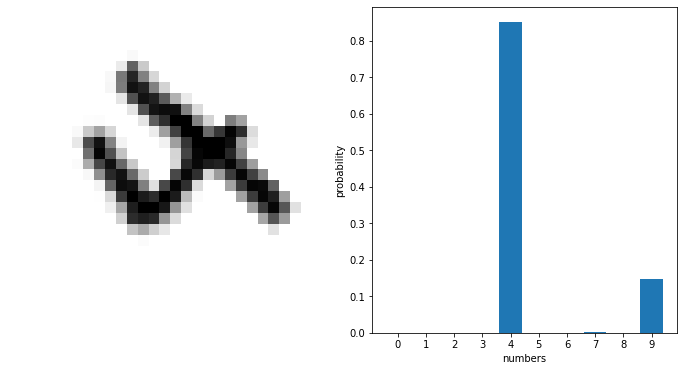

tensor(4)

In [ ]:
ffn.mode = 'curious'
output = ffn(sample_image)
output

As seen above, in the last line of the output, the model predicts the input image to be `tensor(4)`. This demonstrates a Feed Forward Network that is known to not have spatial perception and trained on non-manipulated images is able to recognize manipulated images using it's curiosity. The Artificial Curiosity here includes limited types and number of transformations for demonstration purpose. 

## **Versatility** 

How to measure versatility of the model with the use of curiosity?

1. Randomly apply affine transformation to the test data to manipulate it. These manipulated images will be used for evaluating the performance.
2. Use uniform distribution to randomly rotate the data with azimuths 45, 90, 135, 180, 225, 270, 315 degrees. Note that 0 deg is not considered for testing because it is important to exclude common orientations for 'standard' and 'curious' mode, otherwise it may lead to incorrect results.
3. Flip 50% of the data.
4. Predict using 'standard' and 'curious' modes.
5. Use accuracy and F1-score as performance measures.
6. Store the performance from both the modes.
7. Define 'versatility score' as difference between non-curious and curious mode performance.
8. Calculate versatility score.

In [ ]:
# Inspect test loader
for item in test_loader:
  print(item[0].shape)

torch.Size([7000, 784])


In [ ]:
# Generate random azimuths that follows uniform distribution, of size equal to test set.
azimuths = [45, 90, 135, 180, 225, 270, 315]
""" 
Why these specific azimuths? Earlier, we defined artificial curiosity as applying transformations 
to the provided data before predicting and for demonstration purposes only these azimuth values for 
rotational transformations along with a flip were used. For measuring the effect of using artificial curiosity 
on model performance it is necessary to make sure that test data complies with the scope of defined curiosity, 
therefore these values are used.
"""    
unif_dist = []
for angle in azimuths:
  unif_dist.extend([angle]*int(1/len(azimuths)*7000))
unif_dist = np.array(unif_dist)
np.random.shuffle(unif_dist)

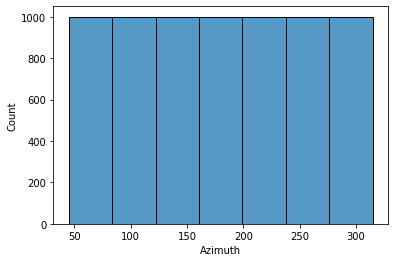

In [ ]:
sns.histplot(data=unif_dist, bins=7)
plt.xlabel('Azimuth')
plt.show()

In [ ]:
# Generate mask to Flip 50% of the test images
flip_mask = np.concatenate([np.ones(3500, dtype=bool), np.zeros(3500, dtype=bool)])
np.random.shuffle(flip_mask)

In [ ]:
# Apply rotational transformation to the images in the testloader using the generated azimuths.
manip_images = []
ground_truth = []
for image_id, azimuth, flip_state in zip(range(7000), unif_dist, flip_mask):
  sample_image = next(iter(test_loader))[0][image_id].reshape(28, 28)
  sample_label = next(iter(test_loader))[1][image_id]
  ground_truth.append(sample_label)
  sample_image = np.array(sample_image.detach())
  if flip_state:
    sample_image = cv2.flip(sample_image, 1) 
  rows, cols = sample_image.shape[:2]
  center = (cols/2, rows/2)
  rotation_matrix = cv2.getRotationMatrix2D(center, azimuth, 1)
  rotated_image = cv2.warpAffine(sample_image, rotation_matrix,  (cols, rows))
  image = torch.tensor(rotated_image.reshape(1, -1))
  manip_images.append(image)
  msg = 'Completed {}/{}'.format(image_id, 7000)
  sys.stdout.write('\r' + msg)

Completed 6999/7000

In [ ]:
test_images = iter(manip_images)

In [ ]:
# predict using 'standard' mode
def predict_standard_mode(info: bool, images) -> list:
  ffn.mode = 'standard'
  ffn.info = info

  std_preds = []
  for img in images:
    std_log_softmax = ffn(img)
    std_pred = torch.argmax(std_log_softmax, axis=1)
    std_preds.append(std_pred.squeeze())
  return std_preds

In [ ]:
std_preds = predict_standard_mode(info=False, images=test_images)

In [ ]:
# Compare standard mode predictions with ground truth values
std_accuracy = accuracy_score(ground_truth, std_preds)
std_accuracy

0.24642857142857144

In [ ]:
test_images = iter(manip_images)

In [ ]:
# predict using 'curious' mode
def predict_curious_mode(info: bool, images) -> list:
  ffn.mode = 'curious'
  ffn.info = info

  cur_preds = []
  for img in images:
    cur_pred = ffn(img)
    cur_preds.append(cur_pred.squeeze())
  return cur_preds

In [ ]:
cur_preds = predict_curious_mode(info=False, images=test_images)

In [ ]:
# Compare curious mode predictions with the ground truth values
cur_accuracy = accuracy_score(ground_truth, cur_preds)
cur_accuracy

0.6121428571428571

In [ ]:
# Calculate 'Versatility score'
v_score = np.abs(cur_accuracy - std_accuracy)
v_score

0.36571428571428566

## **Expermiment**

The objective of this experiment is to test whether this approach to artificial curiosity in the context of MNIST image classification results in overall better performance of the model in handling manipulated data.

#### Methodology

1. Pick 'n' random samples from 'manip_images'. (Random Sampling with replacement)
2. Predict in Standard mode and measure performance.
3. Predict in Curious mode and measure performance.
4. Calculate versatility score for the experiment.
5. Repeat the experiment 50 times.
6. Conduct a hypothesis test.


In [ ]:
standard_mode_accuracies = []
curious_mode_accuracies = []
v_scores = []

# 5. Repeat the experiment 50 times
for exp in range(50):

  # 1. Pick 'n' random samples from 'manip_images'.
  subject_idx = np.random.choice(a=np.arange(7000), size=1000, replace=False)
  subject_images = [manip_images[i] for i in subject_idx]
  subject_labels = [ground_truth[i] for i in subject_idx]

  # 2. Predict in standard mode and measure performance.
  std_pred = predict_standard_mode(info=False, images = subject_images)
  std_accuracy = accuracy_score(subject_labels, std_pred)
  standard_mode_accuracies.append(std_accuracy)

  # 3. Predict in curious mode and measure performance
  cur_pred = predict_curious_mode(info=False, images = subject_images)
  cur_accuracy = accuracy_score(subject_labels, cur_pred)
  curious_mode_accuracies.append(cur_accuracy)

  # 4. Calculate versatility score for the experiment
  v = np.abs(cur_accuracy - std_accuracy)
  v_scores.append(v)
  
  msg = "Experiment: {}/{}".format(exp, 50)
  sys.stdout.write('\r' + msg)

Experiment: 49/50

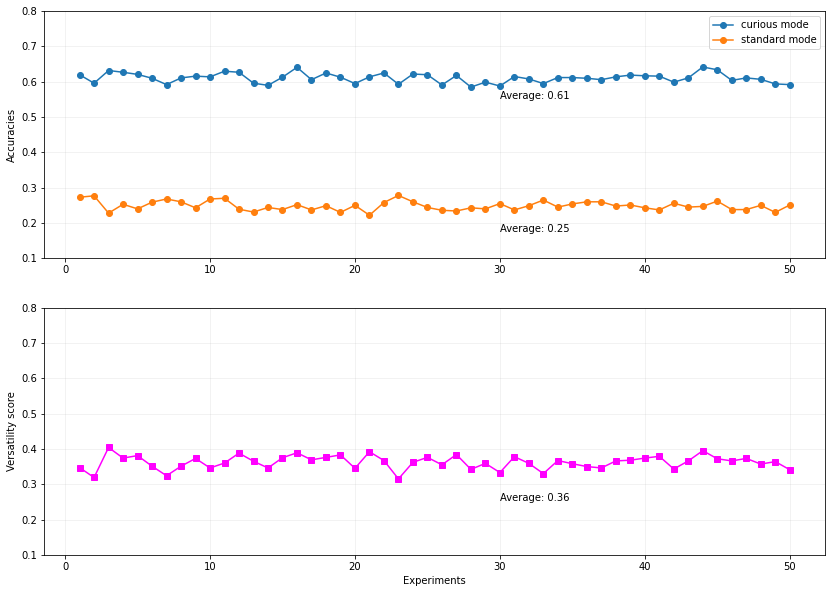

In [ ]:
# Visualise the performance
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

ax[0].plot(np.arange(1, 51), curious_mode_accuracies, marker='o')
ax[0].plot(np.arange(1, 51), standard_mode_accuracies, marker='o')
ax[0].set_ylabel('Accuracies')
ax[0].set_ylim(0.1, 0.8)
ax[0].legend(['curious mode', 'standard mode'], loc='upper right')
ax[0].text(30, np.mean(curious_mode_accuracies)*0.90, 'Average: {:.2f}'.format(np.mean(curious_mode_accuracies)))
ax[0].text(30, np.mean(standard_mode_accuracies)*0.70, 'Average: {:.2f}'.format(np.mean(standard_mode_accuracies)))
ax[0].grid(alpha=0.2)

ax[1].plot(np.arange(1, 51), v_scores, marker = 's', color='magenta')
ax[1].set_xlabel('Experiments')
ax[1].set_ylabel('Versatility score')
ax[1].set_ylim(0.1, 0.8)
ax[1].text(30, np.mean(v_scores)*0.70, 'Average: {:.2f}'.format(np.mean(v_scores)))
ax[1].grid(alpha=0.2)

plt.show()

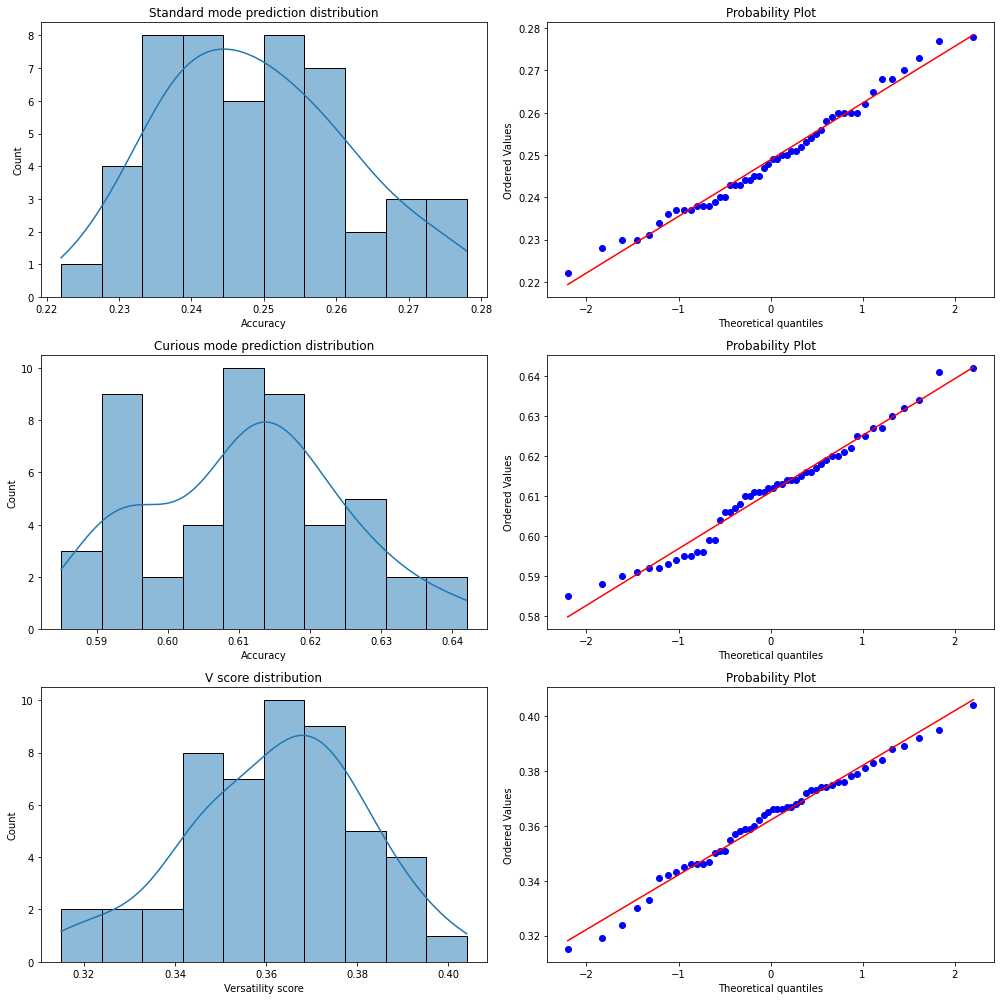

In [ ]:
plt.figure(figsize=(14, 14))

plt.subplot(3,2,1)
sns.histplot(data=standard_mode_accuracies, bins=10, kde=True)
plt.title('Standard mode prediction distribution')
plt.xlabel('Accuracy')

plt.subplot(3,2,2)
stats.probplot(standard_mode_accuracies, dist='norm', plot=plt)

plt.subplot(3,2,3)
sns.histplot(data=curious_mode_accuracies, bins=10, kde=True)
plt.title('Curious mode prediction distribution')
plt.xlabel('Accuracy')

plt.subplot(3,2,4)
stats.probplot(curious_mode_accuracies, dist='norm', plot=plt)

plt.subplot(3,2,5)
sns.histplot(data=v_scores, bins=10, kde=True)
plt.title('V score distribution')
plt.xlabel('Versatility score')

plt.subplot(3,2,6)
stats.probplot(v_scores, dist='norm', plot=plt)
plt.tight_layout()
plt.show()

- Above plots show that the data (standard and curious mode predictions, also their differences; V score) is approximately normally distributed.
- The First two histograms also show that the variance are roughly equal. In the first subplot, the accuracies range roughly from 0.22 to 0.28 about 0.06 points. Similarly in the second subplot the accuracies range from roughly 0.58 to 0.64 again about 0.06 points. 

## **Hypothesis Testing**

**Null Hypothesis ($H_0$): μ_standard = μ_curious**<br>
The performance of a model in standard and curious modes in classifying manipulated images is not significantly different.

**Alternate Hypothesis ($H_A$): μ_standard != μ_curious**<br>
The performance of a model in standard and curious modes in classifying manipulated images is significantly different.

In [ ]:
statistic, p = ttest_ind(standard_mode_accuracies, curious_mode_accuracies)

print("t-statistic:", statistic)
print("p-value:", p)

t-statistic: -133.76745900019637
p-value: 9.50346802865236e-113


The p-value obtained from the test is very small (9.50346802865236e-113), which is well below the common significance level of 0.05. This means we can reject the null hypothesis that there is no significant difference between the mean accuracy of the standard mode and curious mode.

The negative t-statistic value of -133.767 indicates that the curious mode has a significantly higher mean accuracy than the standard mode.

The experiment has provided evidence that the curious mode leads to a significant improvement in the model's ability to handle manipulated data compared to the standard mode.

******